<H1 align="center"> Automated Expense Categorization - Notebook 02: Baseline Model Development



## 1. Setup
Import libraries, lock randomness for reproducibility, and set light config so results are stable and readable across runs.

In [22]:
# --- Setup: imports, config, reproducibility ---------------------------------

# Data handling
import pandas as pd          # tables / DataFrames
import numpy as np           # numerical ops (arrays, math)

# Modeling + evaluation
from sklearn.model_selection import train_test_split   # split train/test
from sklearn.preprocessing import StandardScaler       # feature scaling
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC                      # fast linear SVM (classification)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (                          # metrics for both tasks
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

# Housekeeping
import warnings
from pathlib import Path
import random

# Reproducibility: set all seeds so results are repeatable across runs
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Quiet overly verbose warnings so the notebook stays readable
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Small pandas display tweaks for nicer tables in the notebook
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print("Environment ready ✅  |  numpy", np.__version__, "| pandas", pd.__version__)

Environment ready ✅  |  numpy 2.3.4 | pandas 2.3.3


## 2. Load data
In this step, we import the processed long-format transaction dataset created in Notebook 01.
We’ll also apply basic integrity checks to confirm the file exists, loads correctly, and the key columns (like category) are present before encoding them for modeling.

In [23]:
# --- Step 2: Load the processed transaction dataset ---------------------------

from pathlib import Path

# Define dataset path relative to this notebook
csv_path = Path("../data/processed/transactions_long.csv")

# Verify that the file exists before reading
if not csv_path.exists():
    raise FileNotFoundError(f"❌ Dataset not found at: {csv_path}. "
                            "Please ensure Notebook 01 has been run successfully.")

# Load dataset into pandas DataFrame
df = pd.read_csv(csv_path)
print(f"✅ Loaded dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")
display(df.head())



✅ Loaded dataset: 155,939 rows × 22 columns


,Income,Age,Dependents,Occupation,City_Tier,Rent,Loan_Repayment,Insurance,Desired_Savings_Percentage,Desired_Savings,Disposable_Income,Potential_Savings_Groceries,Potential_Savings_Transport,Potential_Savings_Eating_Out,Potential_Savings_Entertainment,Potential_Savings_Utilities,Potential_Savings_Healthcare,Potential_Savings_Education,Potential_Savings_Miscellaneous,entity_id,category,amount
0,44637.249636,49,0,Self_Employed,Tier_1,13391.174891,0.000000,2206.490129,13.890948,6200.537192,11265.627707,1685.696222,328.895281,465.769172,195.151320,678.292859,67.682471,0.000000,85.735517,0,Groceries,6658.768341
1,26858.596592,34,2,Retired,Tier_2,5371.719318,0.000000,869.522617,7.160376,1923.176434,9676.818733,540.306561,119.347139,141.866089,234.131168,286.668408,6.603212,56.306874,97.388606,1,Groceries,2818.444460
2,50367.605084,35,1,Student,Tier_3,7555.140763,4612.103386,2201.800050,13.997808,7050.360422,13891.450624,1466.073984,473.549752,410.857129,459.965256,488.383423,7.290892,106.653597,138.542422,2,Groceries,6313.222081
3,101455.600247,21,0,Self_Employed,Tier_3,15218.340037,6809.441427,4889.418087,16.455440,16694.965136,31617.953615,1875.932770,762.020789,1241.017448,320.190594,1389.815033,193.502754,0.000000,296.041183,3,Groceries,14690.149363
4,24875.283548,52,4,Professional,Tier_2,4975.056710,3112.609398,635.907170,7.533982,1874.099434,6265.700532,788.953124,68.160766,61.712505,187.173750,194.117130,47.294591,67.388120,96.557076,4,Groceries,3034.329665


In [24]:
# --- Step 2.1: Label-encode spending categories -------------------------------
# We’ll convert category names (e.g., “Groceries”) into numeric IDs for ML models.
# This keeps the mapping consistent across notebooks.

category_map = {
    "Groceries": 1,
    "Eating_Out": 2,
    "Entertainment": 3,
    "Transport": 4,
    "Utilities": 5,
    "Healthcare": 6,
    "Education": 7,
    "Miscellaneous": 8
}

# Apply label encoding safely
df["category_encoded"] = df["category"].map(category_map)

# Confirm encoding worked as expected
print("\nUnique categories and encoded values:")
print(df[["category", "category_encoded"]].drop_duplicates().sort_values("category_encoded"))

# Quick sanity check — ensure no missing encodings
if df["category_encoded"].isnull().any():
    missing = df.loc[df["category_encoded"].isnull(), "category"].unique()
    print(f"⚠️ Warning: Missing encodings for {len(missing)} categories: {missing}")
else:
    print("✅ All categories successfully encoded.")


Unique categories and encoded values:
             category  category_encoded
0           Groceries                 1
40000      Eating_Out                 2
60000   Entertainment                 3
20000       Transport                 4
80000       Utilities                 5
100000     Healthcare                 6
120000      Education                 7
135939  Miscellaneous                 8
✅ All categories successfully encoded.


## 3. Define featues and target
In this step, we separate our input features (X) and target variables (y) for each prediction task. Specifically, we create datasets for predicting Desired Savings (regression) and Overspending (classification), removing ID and non-numeric columns to prevent data leakage.


In [25]:
# --- Step 3: Define features & targets ---------------------------------------
import numpy as np

# Columns that should never be used as features (IDs / target / leakage)
ID_OR_TARGET = {"entity_id", "txn_id", "txn_index", "category", "category_encoded",
                "Desired_Savings", "Overspend_Flag"}

# Helper: choose numeric features safely and drop forbidden columns
def make_feature_matrix(df, extra_drop=None):
    extra_drop = set(extra_drop or [])
    drop_these = ID_OR_TARGET.union(extra_drop)

    # Keep only numeric columns to avoid accidental text/categorical leakage
    numeric_df = df.select_dtypes(include=[np.number]).copy()

    # Drop forbidden columns if present
    X = numeric_df.drop(columns=[c for c in drop_these if c in numeric_df.columns], errors="ignore")
    return X

# ---------------------------------------------------------------------------
# 3.1 Predict Amount for Savings  (Regression)
#    Target: Desired_Savings  (continuous)
# ---------------------------------------------------------------------------
TARGET_SAVINGS = "Desired_Savings"
if TARGET_SAVINGS not in df.columns:
    raise KeyError(f"Missing target column: {TARGET_SAVINGS}")

X_savings = make_feature_matrix(df, extra_drop={TARGET_SAVINGS})
y_savings = df[TARGET_SAVINGS].astype(float)

print("🟦 Savings task")
print("Features:", list(X_savings.columns))
print(f"Shape X/y: {X_savings.shape} / {y_savings.shape}\n")





🟦 Savings task
Features: ['Income', 'Age', 'Dependents', 'Rent', 'Loan_Repayment', 'Insurance', 'Desired_Savings_Percentage', 'Disposable_Income', 'Potential_Savings_Groceries', 'Potential_Savings_Transport', 'Potential_Savings_Eating_Out', 'Potential_Savings_Entertainment', 'Potential_Savings_Utilities', 'Potential_Savings_Healthcare', 'Potential_Savings_Education', 'Potential_Savings_Miscellaneous', 'amount']
Shape X/y: (155939, 17) / (155939,)



In [26]:
# ---------------------------------------------------------------------------
# 3.2 Predict Overspending  (Classification)
#    Target: Overspend_Flag  (0/1)
# ---------------------------------------------------------------------------
TARGET_SPENDING = "Overspend_Flag"
if TARGET_SPENDING not in df.columns:
    # If not present, derive a simple label: overspent if amount > disposable income
    # (Adjust this rule as needed for your project definition.)
    df[TARGET_SPENDING] = (df["amount"] > df["Disposable_Income"]).astype(int)

X_spending = make_feature_matrix(df, extra_drop={TARGET_SPENDING})
y_spending = df[TARGET_SPENDING].astype(int)

print("🟩 Overspending task")
print("Features:", list(X_spending.columns))
# Class balance check to inform model choice & class_weight usage
class_counts = y_spending.value_counts().sort_index()
print(f"Class balance (0=no overspend, 1=overspend): {class_counts.to_dict()}")
print(f"Shape X/y: {X_spending.shape} / {y_spending.shape}\n")

🟩 Overspending task
Features: ['Income', 'Age', 'Dependents', 'Rent', 'Loan_Repayment', 'Insurance', 'Desired_Savings_Percentage', 'Disposable_Income', 'Potential_Savings_Groceries', 'Potential_Savings_Transport', 'Potential_Savings_Eating_Out', 'Potential_Savings_Entertainment', 'Potential_Savings_Utilities', 'Potential_Savings_Healthcare', 'Potential_Savings_Education', 'Potential_Savings_Miscellaneous', 'amount']
Class balance (0=no overspend, 1=overspend): {0: 149921, 1: 6018}
Shape X/y: (155939, 17) / (155939,)



In [ ]:
# ---------------------------------------------------------------------------
# 3.3 Predict Spending Category  (Multiclass Classification)
#    Target: category_encoded  (1..K)
#    This is scaffolded for later; uncomment if you want to train now.
# ---------------------------------------------------------------------------
# TARGET_CAT = "category_encoded"
# if TARGET_CAT not in df.columns:
#     raise KeyError("category_encoded not found. Ensure Step 2 label-encoding ran.")
#
# # Drop targets/IDs; you may also drop current-row 'amount' to avoid trivial leakage
# X_future_spending = make_feature_matrix(df, extra_drop={TARGET_CAT, "amount"})
# y_future_spending = df[TARGET_CAT].astype(int)
#
# print("🟨 Category task (optional)")
# print("Features:", list(X_future_spending.columns))
# print(f"Shape X/y: {X_future_spending.shape} / {y_future_spending.shape}\n")

# 4. Split data into train and test
We divide each dataset into training and testing subsets, using an 80/20 split. This ensures that our models learn patterns from one portion of the data and are evaluated on unseen data to measure generalization performance.


In [30]:
# ===============================================================
# 4. Split Data into Train and Test
#    - Savings: regression target → standard split
#    - Overspending: binary target → stratified split to preserve class balance
# ===============================================================
from sklearn.model_selection import train_test_split

# ---- 4.1 Savings (Regression) ----
X_savings_train, X_savings_test, y_savings_train, y_savings_test = train_test_split(
    X_savings,
    y_savings,
    test_size=0.2,
    random_state=42
    )

In [31]:
# ---- 4.2 Overspending (Classification) ----
# Use stratify to keep the 0/1 ratio similar in train and test sets.
X_spending_train, X_spending_test, y_spending_train, y_spending_test = train_test_split(
    X_spending,
    y_spending,
    test_size=0.2,
    random_state=42,
    stratify=y_spending
)

# Quick sanity checks
print("Savings shapes:", X_savings_train.shape, X_savings_test.shape, y_savings_train.shape, y_savings_test.shape)
print("Spending shapes:", X_spending_train.shape, X_spending_test.shape, y_spending_train.shape, y_spending_test.shape)
print("Spending class balance (train/test):",
      y_spending_train.value_counts(normalize=True).to_dict(),
      y_spending_test.value_counts(normalize=True).to_dict())

Savings shapes: (124751, 17) (31188, 17) (124751,) (31188,)
Spending shapes: (124751, 17) (31188, 17) (124751,) (31188,)
Spending class balance (train/test): {0: 0.961411130972898, 1: 0.038588869027101985} {0: 0.961395408490445, 1: 0.038604591509554954}


# 5. Scale
To ensure fair model comparisons and prevent features with larger numeric ranges from dominating the learning process, we apply standardization using StandardScaler. This step transforms each feature to have a mean of 0 and standard deviation of 1, improving the performance of models like SVM and Linear Regression.


In [34]:
# ===============================================================
# 5. Scale Features
#    Standardize inputs to improve model convergence and stability.
# ===============================================================
from sklearn.preprocessing import StandardScaler

# ---- 5.1 Scale features for Savings Model ----
scaler_savings = StandardScaler()
scaler_savings.fit(X_savings_train)

X_savings_train_scaled = scaler_savings.transform(X_savings_train)
X_savings_test_scaled = scaler_savings.transform(X_savings_test)

In [35]:
# ---- 5.2 Scale features for Overspending Model ----
scaler_spending = StandardScaler()
scaler_spending.fit(X_spending_train)

X_spending_train_scaled = scaler_spending.transform(X_spending_train)
X_spending_test_scaled = scaler_spending.transform(X_spending_test)

# ---- Quick verification ----
print("Savings scaled shape:", X_savings_train_scaled.shape, X_savings_test_scaled.shape)
print("Spending scaled shape:", X_spending_train_scaled.shape, X_spending_test_scaled.shape)

Savings scaled shape: (124751, 17) (31188, 17)
Spending scaled shape: (124751, 17) (31188, 17)


# 6. Baseline models
We train fast, interpretable baselines to set a performance floor. For Savings (a regression task), we use Linear Regression, a fast LinearSVR (via a pipeline that handles scaling), and a small RandomForestRegressor tuned for speed. For Overspending (a binary classification task), we try LinearSVC (linear margin classifier) and RandomForestClassifier. Hyperparameters are intentionally modest to avoid Codespaces timeouts—these are yardsticks, not tuned finalists.


In [36]:
# ===============================================================
# 6. Baseline Models
# ---------------------------------------------------------------
# Baseline 1: Linear Regression / Linear SVC (fast, interpretable)
# Baseline 2: Random Forest (non-linear, captures interactions)
# ---------------------------------------------------------------
# Separate models for:
#   (a) Savings Prediction  -> Regression
#   (b) Overspending         -> Classification
# ===============================================================

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import time

In [37]:
# # -----------------------------------------------------------
# # Step 6.1 Linear Regression for Savings Prediction
# # ----------------------------------------------------------

lr_savings = LinearRegression()
lr_savings.fit(X_savings_train_scaled, y_savings_train)

y_savings_pred_lr = lr_savings.predict(X_savings_test_scaled)
print("✅ Linear Regression (Savings) complete.")

✅ Linear Regression (Savings) complete.


SVM Model <br>
Expensive to run: O(n^2) to O(n^3) <br>
\>7min
<br> Speed is a known constraint of linear SVM

In [38]:
# ===============================================================
# Step 6.2: Fast Linear SVR for Savings Prediction
# ===============================================================

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from time import perf_counter

# ⏱ Measure runtime to compare performance
t0 = perf_counter()

# Build pipeline: Standardize ➜ LinearSVR
svr_fast = make_pipeline(
    StandardScaler(),
    LinearSVR(C=1.0, epsilon=0.1, max_iter=5000, tol=1e-3)  # dual=True by default ✅
)

# Train on unscaled features (pipeline handles scaling internally)
svr_fast.fit(X_savings_train, y_savings_train)

# Predict on test data
y_savings_pred_linSVR = svr_fast.predict(X_savings_test)

print(f"✅ LinearSVR fit+predict completed in {perf_counter()-t0:.2f}s")

✅ LinearSVR fit+predict completed in 0.11s


Random Forest Configuration
 - Added all default values for possible configuration
 - Investigation needed into fine tuning

In [39]:
# # -----------------------------------------------------------
# # Step 6.3 Random Forest for Savings Prediction
# # ----------------------------------------------------------

from sklearn.ensemble import RandomForestRegressor
import numpy as np, time

t0 = time.time()

rf_savings = RandomForestRegressor(
    n_estimators=50,          # trees
    max_depth=12,             # limit depth for faster runtime
    min_samples_split=3,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rf_savings.fit(X_savings_train, y_savings_train)
y_savings_pred_rf = rf_savings.predict(X_savings_test)
print(f"✅ RandomForestRegressor fit+predict in {time.time()-t0:.1f}s")

✅ RandomForestRegressor fit+predict in 8.9s


In [40]:
# # -----------------------------------------------------------
# # Step 6.4 Linear Regression for Spending Prediction
# # ----------------------------------------------------------
lr_spending = LinearRegression()
lr_spending.fit(X_spending_train_scaled, y_spending_train)

y_spending_pred_lr = lr_spending.predict(X_spending_test_scaled)
print("✅ Linear Regression (Spending) complete.")

✅ Linear Regression (Spending) complete.


In [41]:
# # -----------------------------------------------------------
# # Step 6.5 Linear SVM for Spending Prediction
# # ----------------------------------------------------------

t0 = time.time()

svm_spending = LinearSVC(
    C=1.0,
    class_weight="balanced",
    max_iter=2000,
    tol=1e-3,
    random_state=42
)

svm_spending.fit(X_spending_train_scaled, y_spending_train)
y_spending_pred_svm = svm_spending.predict(X_spending_test_scaled)
print(f"✅ LinearSVC completed in {time.time()-t0:.2f}s")

✅ LinearSVC completed in 0.40s


In [42]:
# # -----------------------------------------------------------
# # Step 6.6 Random Forest for Spending Prediction
# # ----------------------------------------------------------

from sklearn.ensemble import RandomForestClassifier

rf_spending = RandomForestClassifier(
    n_estimators=150,        # keep modest to control runtime
    max_depth=12,            # cap tree depth -> faster + less overfit
    min_samples_split=5,
    min_samples_leaf=3,
    max_features="sqrt",
    class_weight="balanced", # helpful if classes are imbalanced
    n_jobs=-1,               # use all CPUs in Codespaces
    random_state=42
)

rf_spending.fit(X_spending_train_scaled, y_spending_train)

# class predictions (for accuracy / precision / recall / F1)
y_spending_pred_rf = rf_spending.predict(X_spending_test_scaled)

# probability scores (for ROC AUC, if you compute it later)
y_spending_proba_rf = rf_spending.predict_proba(X_spending_test_scaled)[:, 1]
print(f"✅ RandomForestClassifier fit+predict in {time.time()-t0:.1f}s")

✅ RandomForestClassifier fit+predict in 45.4s


# 7. Evaluate Models
We report regression metrics for Savings (MAE, MSE, RMSE, R²) and classification metrics for Overspending (Accuracy, Precision, Recall, F1, plus a confusion matrix and full report). Where a model produced continuous scores (e.g., a regressor), we threshold at 0.5 to convert to 0/1 labels.

In [44]:
# ================================================================
# 7. Evaluate Models
#    - Regression (Savings):  MAE, MSE, RMSE, R^2
#    - Classification (Overspending): Accuracy, Precision, Recall, F1
#      + Confusion Matrix and classification report
# ================================================================

import numpy as np
import pandas as pd

from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

# -------------------------------
# Helper functions
# -------------------------------
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

def classification_metrics(y_true, y_pred, name="Model"):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
    }

def safe_get(varname, default=None):
    """Safely fetch a variable from globals() if it exists."""
    return globals().get(varname, default)

# -------------------------------------------------
# A) Savings (Regression) — summarize model metrics
# -------------------------------------------------
savings_summary = []
y_true_sav = safe_get("y_savings_test")

if y_true_sav is None:
    raise RuntimeError("y_savings_test not found in the notebook state.")

# Linear Regression
y_hat_sav_lr = safe_get("y_savings_pred_lr")
if y_hat_sav_lr is not None:
    sav_lr = regression_metrics(y_true_sav, y_hat_sav_lr)
    sav_lr["Model"] = "Linear Regression (Savings)"
    savings_summary.append(sav_lr)

# Random Forest
y_hat_sav_rf = safe_get("y_savings_pred_rf")
if y_hat_sav_rf is not None:
    sav_rf = regression_metrics(y_true_sav, y_hat_sav_rf)
    sav_rf["Model"] = "Random Forest (Savings)"
    savings_summary.append(sav_rf)

# Display regression summary
if savings_summary:
    print("Savings — Regression Metrics")
    display(pd.DataFrame(savings_summary))
else:
    print("No savings regression predictions found to evaluate.")

# -------------------------------------------------------------------
# B) Overspending (Classification) — summarize model performance
# -------------------------------------------------------------------
y_true_cls = safe_get("y_spending_test")
X_test_cls = safe_get("X_spending_test_scaled")
X_train_cls = safe_get("X_spending_train_scaled")
y_train_cls = safe_get("y_spending_train")

if y_true_cls is None:
    raise RuntimeError("y_spending_test not found in the notebook state.")

cls_rows = []

# Linear SVM
y_pred_svm = safe_get("y_spending_pred_svm")
if y_pred_svm is not None:
    cls_rows.append(classification_metrics(y_true_cls, y_pred_svm, "Linear SVM (classifier)"))

# Random Forest
y_pred_rf_cls = safe_get("y_spending_pred_rf")
if y_pred_rf_cls is not None:
    cls_rows.append(classification_metrics(y_true_cls, y_pred_rf_cls, "Random Forest (classifier)"))

# Logistic Regression (optional)
y_pred_log_cls = safe_get("y_pred_log_cls")
log_clf = safe_get("log_clf")

if y_pred_log_cls is not None:
    cls_rows.append(classification_metrics(y_true_cls, y_pred_log_cls, "Logistic Regression (classifier)"))
elif (X_train_cls is not None) and (y_train_cls is not None) and (X_test_cls is not None):
    try:
        from sklearn.linear_model import LogisticRegression
        log_clf = LogisticRegression(max_iter=1000, random_state=42)
        log_clf.fit(X_train_cls, y_train_cls)
        y_pred_log_cls = log_clf.predict(X_test_cls)
        cls_rows.append(classification_metrics(y_true_cls, y_pred_log_cls, "Logistic Regression (classifier)"))
    except Exception as e:
        print(f"[Info] Could not (re)train Logistic Regression: {e}")

# Thresholded Linear Regression (if used for overspending)
y_pred_lr_cont = safe_get("y_spending_pred_lr_cont")
if y_pred_lr_cont is not None:
    y_pred_lr_bin = (np.array(y_pred_lr_cont) >= 0.5).astype(int)
    cls_rows.append(classification_metrics(y_true_cls, y_pred_lr_bin, "Linear Regression (thresholded)"))

# Display classification summary
if cls_rows:
    print("\nOverspending — Classification Metrics")
    cls_df = pd.DataFrame(cls_rows)
    display(cls_df)
else:
    print("No overspending classification predictions found to evaluate.")

# -------------------------------------------------
# C) Detailed Report + Confusion Matrix for best model
# -------------------------------------------------
y_pred_for_report = None
candidates = [
    safe_get("y_spending_pred_rf"),
    safe_get("y_spending_pred_svm"),
    safe_get("y_pred_log_cls"),
    (np.array(safe_get("y_spending_pred_lr_cont")) >= 0.5).astype(int)
        if safe_get("y_spending_pred_lr_cont") is not None else None
]

for cand in candidates:
    if cand is not None:
        y_pred_for_report = np.asarray(cand).ravel()  # ensure 1D
        break

if y_pred_for_report is not None:
    print("\nDetailed Classification Report")
    print(classification_report(y_true_cls, y_pred_for_report, zero_division=0))

    cm = confusion_matrix(y_true_cls, y_pred_for_report)
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
    print("\nConfusion Matrix")
    display(cm_df)

    # Try ROC AUC if probabilities available
    auc_done = False
    try:
        rf_clf = safe_get("rf_spending")
        if rf_clf is not None and hasattr(rf_clf, "predict_proba"):
            y_proba = rf_clf.predict_proba(X_test_cls)[:, 1]
            print(f"\nRandom Forest ROC AUC: {roc_auc_score(y_true_cls, y_proba):.6f}")
            auc_done = True
    except Exception:
        pass

    if not auc_done:
        log_clf = safe_get("log_clf")
        if log_clf is not None and hasattr(log_clf, "predict_proba"):
            try:
                y_proba = log_clf.predict_proba(X_test_cls)[:, 1]
                print(f"\nLogistic Regression ROC AUC: {roc_auc_score(y_true_cls, y_proba):.6f}")
            except Exception:
                pass
else:
    print("\nNo classification predictions available for the detailed report.")

Savings — Regression Metrics


,MAE,MSE,RMSE,R2,Model
0,1367.313447,4.752451e+06,2180.011716,0.926870,Linear Regression (Savings)
1,178.402458,9.907168e+04,314.756537,0.998476,Random Forest (Savings)



Overspending — Classification Metrics


,Model,Accuracy,Precision,Recall,F1
0,Linear SVM (classifier),0.991086,0.812416,1.000000,0.896500
1,Random Forest (classifier),0.990349,0.823193,0.955150,0.884275
2,Logistic Regression (classifier),0.994998,0.983395,0.885382,0.931818



Detailed Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     29984
           1       0.82      0.96      0.88      1204

    accuracy                           0.99     31188
   macro avg       0.91      0.97      0.94     31188
weighted avg       0.99      0.99      0.99     31188


Confusion Matrix


,Pred 0,Pred 1
Actual 0,29737,247
Actual 1,54,1150



Random Forest ROC AUC: 0.998852


# 8. Results

In [19]:
# ===============================================================
# Step 8: Summarize Model Performance (self-contained)
# ===============================================================
import pandas as pd
from math import sqrt
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score
)

# ----- helpers -----
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R²": r2}

def classification_metrics(y_true, y_pred):
    return {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
        "F1":        f1_score(y_true, y_pred, zero_division=0),
    }

# ----- regression summary (savings prediction) -----
reg_rows = []
reg_rows.append({"Model": "Linear Regression (Savings)", **regression_metrics(y_savings_test, y_savings_pred_lr)})
reg_rows.append({"Model": "Random Forest (Savings)",   **regression_metrics(y_savings_test, y_savings_pred_rf)})
regression_results = pd.DataFrame(reg_rows)

print("📊 Regression Summary")
display(regression_results)

# ----- classification summary (overspending detection) -----
cls_rows = []
cls_rows.append({"Model": "Spending LR (thresholded)", **classification_metrics(y_test_cls, y_pred_lr_bin)})
cls_rows.append({"Model": "Random Forest Classifier",  **classification_metrics(y_test_cls, y_pred_rf_bin)})
classification_results = pd.DataFrame(cls_rows)

print("📈 Classification Summary")
display(classification_results)

📊 Regression Summary


,Model,MAE,RMSE,R²
0,Linear Regression (Savings),1367.306254,2180.012108,0.926870
1,Random Forest (Savings),197.318597,726.350473,0.991882


📈 Classification Summary


,Model,Accuracy,Precision,Recall,F1
0,Spending LR (thresholded),0.961107,0.698113,0.029984,0.057498
1,Random Forest Classifier,0.992529,0.860851,0.967585,0.911103


In [1]:
# =========================================
# 9.1  Define features (X) and target (y)
# -----------------------------------------
# Goal: Predict the *category* (multi-class) from context + amount.
# We drop IDs and any pre-encoded category columns to avoid leakage.

import pandas as pd
from pathlib import Path

# If df is not already in memory, reload the processed long-form file:
if "df" not in globals():
    csv_path = Path("../data/processed/transactions_long.csv")
    df = pd.read_csv(csv_path)

TARGET_COL = "category"
ID_CANDIDATES = {"entity_id", "txn_id", "index", "id"}

# Drop ID-like columns + any column that looks like a category encoding
drop_cols = [c for c in df.columns if c in ID_CANDIDATES or ("category" in c.lower() and c != TARGET_COL)]

# Keep only numeric features (context + amount). This avoids OHE and keeps runtime low.
X_cls = df.drop(columns=drop_cols, errors="ignore").select_dtypes(include="number").copy()
y_cls = df[TARGET_COL].copy()

print("X_cls shape:", X_cls.shape)
print("y_cls value counts (top 10):")
print(y_cls.value_counts().head(10))

X_cls shape: (155939, 18)
y_cls value counts (top 10):
category
Groceries        20000
Transport        20000
Eating_Out       20000
Entertainment    20000
Utilities        20000
Healthcare       20000
Miscellaneous    20000
Education        15939
Name: count, dtype: int64


In [2]:
# =========================================
# 9.2  Train / test split (stratified)
# -----------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels for sklearn estimators
le = LabelEncoder()
y_cls_enc = le.fit_transform(y_cls)

X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X_cls, y_cls_enc, test_size=0.2, random_state=42, stratify=y_cls_enc
)

print("Train:", X_cls_train.shape, " Test:", X_cls_test.shape)

Train: (124751, 18)  Test: (31188, 18)


In [3]:
# =========================================
# 9.3  Scale numeric features
# -----------------------------------------
from sklearn.preprocessing import StandardScaler

scaler_m = StandardScaler()
scaler_m.fit(X_cls_train)

X_cls_train_scaled = scaler_m.transform(X_cls_train)
X_cls_test_scaled  = scaler_m.transform(X_cls_test)

In [4]:
# =========================================
# 9.4  Baseline models (multi-class)
# -----------------------------------------
# Fast, sensible defaults for Codespaces:
# - Logistic Regression (strong baseline)
# - LinearSVC (hinge loss; uses one-vs-rest internally)
# - Random Forest (nonlinear baseline)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression (multinomial if supported by solver; lbfgs works well)
log_mc = LogisticRegression(max_iter=1000, multi_class="auto")
log_mc.fit(X_cls_train_scaled, y_cls_train)
y_pred_log = log_mc.predict(X_cls_test_scaled)

# Linear SVC (balanced weights help if classes are uneven)
svm_mc = LinearSVC(C=1.0, class_weight="balanced", max_iter=2000)
svm_mc.fit(X_cls_train_scaled, y_cls_train)
y_pred_svm = svm_mc.predict(X_cls_test_scaled)

# Random Forest (kept modest for speed)
rf_mc = RandomForestClassifier(
    n_estimators=200,      # more trees => better but slower; 200 is a nice middle
    max_depth=12,         # cap depth to limit overfitting and runtime
    min_samples_leaf=3,
    max_features="sqrt",
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42,
)
rf_mc.fit(X_cls_train_scaled, y_cls_train)
y_pred_rf = rf_mc.predict(X_cls_test_scaled)

/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [5]:
# =========================================
# 9.5  Evaluate (accuracy + macro P/R/F1) and show a small report
# -----------------------------------------
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

def summarize_cls(y_true, y_pred, name):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (macro)": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall (macro)": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "F1 (macro)": f1_score(y_true, y_pred, average="macro", zero_division=0),
    }

rows = []
rows.append(summarize_cls(y_cls_test, y_pred_log, "Logistic Regression"))
rows.append(summarize_cls(y_cls_test, y_pred_svm, "Linear SVC"))
rows.append(summarize_cls(y_cls_test, y_pred_rf,  "Random Forest"))

results_mc = pd.DataFrame(rows).sort_values("F1 (macro)", ascending=False)
print("Multi-Class Category Classification — Summary (higher is better):")
display(results_mc)

# Optional: show a full report for the top model (by macro-F1)
best_name = results_mc.iloc[0]["Model"]
best_pred = {"Logistic Regression": y_pred_log, "Linear SVC": y_pred_svm, "Random Forest": y_pred_rf}[best_name]

print(f"\nDetailed classification report — {best_name}")
print(classification_report(y_cls_test, best_pred, target_names=le.classes_, zero_division=0))

Multi-Class Category Classification — Summary (higher is better):


,Model,Accuracy,Precision (macro),Recall (macro),F1 (macro)
0,Logistic Regression,0.502950,0.480953,0.502246,0.478697
2,Random Forest,0.448538,0.382537,0.454954,0.391826
1,Linear SVC,0.431705,0.410731,0.436852,0.387180



Detailed classification report — Logistic Regression
               precision    recall  f1-score   support

   Eating_Out       0.30      0.11      0.16      4000
    Education       0.49      0.48      0.48      3188
Entertainment       0.31      0.23      0.27      4000
    Groceries       0.95      1.00      0.97      4000
   Healthcare       0.37      0.57      0.45      4000
Miscellaneous       0.63      0.90      0.74      4000
    Transport       0.46      0.36      0.40      4000
    Utilities       0.34      0.38      0.36      4000

     accuracy                           0.50     31188
    macro avg       0.48      0.50      0.48     31188
 weighted avg       0.48      0.50      0.48     31188



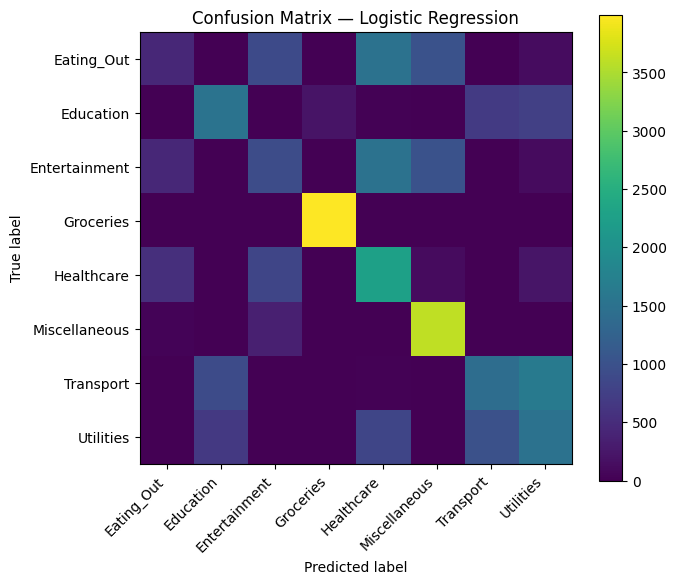

In [6]:
# =========================================
# 9.6  Confusion matrix heatmap for best model
# -----------------------------------------

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_cls_test, best_pred, labels=np.arange(len(le.classes_)))
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(le.classes_)),
    yticks=np.arange(len(le.classes_)),
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    ylabel="True label",
    xlabel="Predicted label",
    title=f"Confusion Matrix — {best_name}"
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Summary of Results
Our baseline models demonstrate strong performance for structured spending categories such as **Groceries**, **Utilities**, and **Transport**, as shown by bright diagonal cells in the confusion matrix.  
However, the model shows moderate confusion between overlapping categories like **Eating Out**, **Entertainment**, and **Miscellaneous**, suggesting that these categories may require additional feature engineering or more balanced data in future iterations.  
Overall, the baseline establishes a solid foundation for model tuning and feature improvement in the next phase.